In [44]:
import s3fs
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import datetime
import warnings

# Rapids and BlazingSQL modules
import cudf
import blazingsql as bsql

import cuml
from cuml.ensemble import RandomForestRegressor as curfr
from cuml.experimental.preprocessing import StandardScaler as cuss, ColumnTransformer as cuColTrnfr
from cuml.preprocessing import LabelBinarizer, LabelEncoder
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.metrics.regression import r2_score
from cuml.metrics import mean_squared_error

import cupy as cp
import cupyx

# Sklearn modules
from sklearn.ensemble import RandomForestClassifier as skrfc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Xgboost
import xgboost as xgb

# Custom modules
from ml_utils import preprocessing_utils as prep

### Create the BlazingSQL BlazingContext

In [21]:
bc = bsql.BlazingContext(enable_progress_bar=True)

BlazingContext ready


## Fetch our NYC Taxi data from BlazingSQL S3 bucket
Only one csv will be be brought in due to memory limitations on device

In [3]:
# Intiate S3 instance and take a look at the files in the nytaxi bucket
s3 = s3fs.S3FileSystem(anon=True)
s3.glob('s3://bsql/data/nytaxi/yellow/2016/')

['bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-01.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-02.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-03.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-04.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-05.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-06.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-07.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-08.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-09.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-10.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-11.csv',
 'bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-12.csv']

In [7]:
# Fetch the Jan-2016 data from AWS S3
taxi = cudf.read_csv('s3://bsql/data/nytaxi/yellow/2016/yellow_tripdata_2016-01.csv', storage_options={'anon': True})

In [8]:
print(f'Data size: {taxi.shape[0]:,} x {taxi.shape[1]}')

Data size: 10,906,858 x 19


In [7]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


In [22]:
taxi.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

## EDA w/ BlazingSQL

In [26]:
bc.create_table('taxi', taxi)

#### Average tip by passenger_count

In [27]:
avg_tip_by_pass = bc.sql('''
    SELECT
        passenger_count
        , AVG(tip_amount) AS avg_tip
    FROM taxi
    GROUP BY
        passenger_count
    ORDER BY passenger_count
''')

Steps Complete 0/9|          |  0% (00:00 elapsed)

Total Batches Processed: 0

<AxesSubplot:xlabel='passenger_count'>

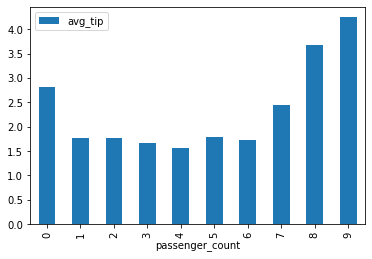

In [28]:
avg_tip_by_pass.to_pandas().plot(x='passenger_count', y='avg_tip', kind='bar')

#### Average total_amount by passenger_count

Steps Complete 0/9|          |  0% (00:00 elapsed)

Total Batches Processed: 0

<AxesSubplot:xlabel='passenger_count'>

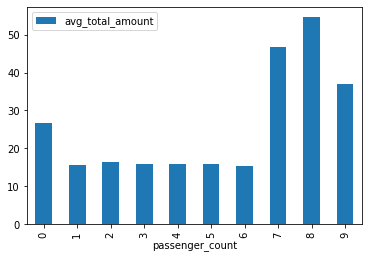

In [29]:
avg_amt_by_pass = bc.sql('''
    SELECT
        passenger_count
        , AVG(total_amount) AS avg_total_amount
    FROM taxi
    GROUP BY
        passenger_count
    ORDER BY passenger_count
''')

avg_amt_by_pass.to_pandas().plot(x='passenger_count', y='avg_total_amount', kind='bar')

In [30]:
bc.sql('''
    SELECT
            COUNT(*) as total_count
        FROM taxi
''')

Steps Complete 0/4|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,total_count
0,10906858


#### Distribution of passenger_count

Steps Complete 0/15|          |  0% (00:00 elapsed)

Total Batches Processed: 0

<AxesSubplot:xlabel='passenger_count'>

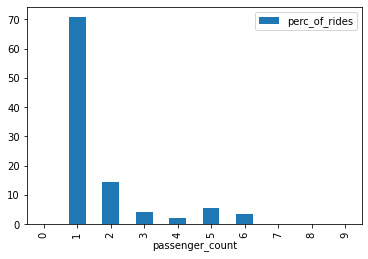

In [32]:
pass_dist = bc.sql('''
        SELECT
            passenger_count
            , CAST(ROUND(100.0 * (COUNT(passenger_count)) /
            (SELECT COUNT(*) FROM taxi), 2) AS FLOAT) as perc_of_rides
        from taxi
        GROUP BY
            passenger_count
        ORDER BY
            passenger_count
''')
pass_dist.to_pandas().plot(x='passenger_count', y='perc_of_rides', kind='bar')

#### Distinct RatecodeID

In [34]:
bc.sql('''
    SELECT DISTINCT RatecodeID, COUNT(*) FROM taxi GROUP BY RatecodeID
''')

Steps Complete 0/5|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,RatecodeID,COUNT(*)
0,1,10626315
1,2,225019
2,3,16822
3,4,4696
4,5,33688
5,6,102
6,99,216


#### Distinct payment_type

In [ ]:
bc.sql('''
    SELECT DISTINCT payment_type, COUNT(*) FROM taxi GROUP BY payment_type
''')

Steps Complete 0/5|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,payment_type,COUNT(*)
0,1,7181476
1,2,3673651
2,3,38319
3,4,13411
4,5,1


#### Distinct improvement_surcharge

In [35]:

bc.sql('''
    SELECT DISTINCT improvement_surcharge, COUNT(*) FROM taxi GROUP BY improvement_surcharge
''')


Steps Complete 0/5|          |  0% (00:00 elapsed)

Total Batches Processed: 0

,improvement_surcharge,COUNT(*)
0,-0.30,4202
1,0.00,1609
2,0.10,5
3,0.12,1
4,0.16,1
5,0.25,1
6,0.30,10901039


## Building a data pipeline and predicting fare_amount with RapidsAI

In [37]:
# drop all null values
taxi = taxi.dropna(axis="rows")

In [8]:
print(f'Data size: {taxi.shape[0]:,} x {taxi.shape[1]}')

Data size: 10,906,858 x 19


In [5]:
class TimeCosSin(BaseEstimator, TransformerMixin):
    """
    Extract signals out of a timestamp feature
    """
     
    @property
    def date_time(self):
        return pd.to_datetime(self.X.pop('tpep_pickup_datetime').to_pandas(), format='%Y-%m-%d %H:%M:%S') 
            
    @property 
    def timestamp(self):
        return self.date_time.map(datetime.datetime.timestamp)
        
    @property
    def feature_names(self):
        return ["Hour_sin", "Hour_cos", 'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']
        
    def fit( self, X, y = None  ):
        return self
    
    def transform(self, X, y=None):
        self.X = X.to_pandas()
        hour = 60*60
        day = 24*hour 
        year = (365.2425)*day
        
        timestamp_s = self.timestamp()
        self.X['Hour_sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
        self.X['Hour_cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
        self.X['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
        self.X['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
        self.X['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        self.X['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        
        return self.X
        
    def get_feature_names(self, input_features=None):
        return self.feature_names

#### Use just a sample of columns to predict our target variable

In [11]:
scale_cols = ["trip_distance"]
label_cols = ["VendorID", "payment_type", "passenger_count"]
y_feat = "fare_amount"

#### Using custom Scikit-Learn compatible RapidsAI transformer classes and built-in RapidsAI transformers to build a Scikit-Learn pipeline
Custom classes from [](https://gist.github.com/wphicks/6233758c1d83014f54891ba617300b48)

In [12]:
X = taxi[scale_cols + label_cols]
y = taxi[y_feat]
X_train, X_test, y_train, y_test = cu_train_test_split(X, y=y, train_size=0.9)

In [13]:
y_scaler = cuss()
y_train = y_scaler.fit_transform(cudf.DataFrame(y_train))
y_test = y_scaler.transform(cudf.DataFrame(y_test))

In [14]:
scaler_transformer = prep.SubsetTransformer(
    cuss(),
    include_dtypes=['integer', 'floating'],
    columns=scale_cols
)

label_transformer = prep.SubsetTransformer(
    prep.PerFeatureTransformer(LabelEncoder, transformer_kwargs={'handle_unknown': 'ignore'}),
    columns=label_cols
)

pipeline = Pipeline([
    ("scaler", scaler_transformer),
    ("labeler", label_transformer)
])

In [15]:
X_train = pipeline.fit_transform(X_train, y_train)

In [16]:
X_train.head()

,trip_distance,VendorID,payment_type,passenger_count
2991675,-0.001275,1,0,3
3335278,0.002686,0,1,2
4823779,-0.000241,0,0,2
7617066,-0.001159,1,0,1
1310778,-0.001181,0,0,1


#### Build and train a Random Forest Regression model 
Also timing the training of the model to show fast cuml is by using the GPU

In [17]:
%%time
model = curfr(n_estimators=100,
              max_depth=3,
              min_samples_leaf=1
             )

model.fit(X_train.astype(np.float32), y_train.astype(np.float32))

CPU times: user 4min 26s, sys: 0 ns, total: 4min 26s
Wall time: 1min 41s


RandomForestRegressor()

In [18]:
%%time
X_test = pipeline.transform(X_test).astype(np.float32)
y_test = y_test.astype(np.float32)

predictions = model.predict(X_test)
r2 = r2_score(y_test.astype(np.float32), predictions)
print(f"R2_score {r2}")

R2_score 0.7875516414642334
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 335 ms


In [46]:
rmse_rf = np.sqrt(mean_squared_error(y_test.astype(np.float32), predictions)) 
print(f'Random Forest RMSE {rmse_rf}')

Random Forest RMSE 0.13442900776863098


### Let's try XgBoost

In [42]:
%%time
## Create train and test dmatrix
dtrain = xgb.DMatrix(
        X_train,
        y_train    )

dtest = xgb.DMatrix(
        X_test,
        y_test    )

## Train the model
trained_model = xgb.train(
                        {
                          'learning_rate': 0.1,
                          'colsample_bytree' : 0.3,
                          'max_depth': 3,
                          'objective': 'reg:squarederror',
                          'n_estimators':10,
                          'alpha' : 10,
                          'silent': True,
                          'verbose_eval': True,
                          'tree_method':'gpu_hist',
                          'scoring': 'r2'
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])

## Predict the model
prediction = trained_model.predict(dtest)

[02:00:48] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1628090879278/work/src/learner.cc:573: 
Parameters: { "n_estimators", "scoring", "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1.09073
[1]	train-rmse:1.07295
[2]	train-rmse:1.05832
[3]	train-rmse:1.04135
[4]	train-rmse:1.03148
[5]	train-rmse:1.02342
[6]	train-rmse:1.01682
[7]	train-rmse:1.01146
[8]	train-rmse:1.00708
[9]	train-rmse:1.00353
[10]	train-rmse:1.00065
[11]	train-rmse:0.99405
[12]	train-rmse:0.99214
[13]	train-rmse:0.99059
[14]	train-rmse:0.98934
[15]	train-rmse:0.98481
[16]	train-rmse:0.98397
[17]	train-rmse:0.98329
[18]	train-rmse:0.98274
[19]	train-rmse:0.98230
[20]	train-rmse:0.98194
[21]	train-rmse:0.98165
[22]	train-rmse:0.97854
[23]	train-rmse:0.97834
[24]	t

In [50]:
r2_xgb = r2_score(y_test.astype(np.float32), prediction)
rmse_xgb = np.sqrt(mean_squared_error(y_test.astype(np.float32), prediction))
print(f"R2_score of Xgboost {r2_xgb}")
print(f"Xgboost RMSE {rmse_xgb}")

R2_score of Xgboost 0.8020240664482117
Xgboost RMSE 0.12976941466331482


## Save the trained models

In [48]:
!mkdir saved_models

In [52]:
rf_file = './saved_models/cuml_random_forest_model.sav'
xgb_file = './saved_models/cuml_xgboost_model.dat'

pickle.dump(model, open(rf_file, 'wb'))
pickle.dump(trained_model, open(xgb_file, 'wb'))

In [55]:
!ls saved_models -alth

total 284K
drwxr-xr-x 7 1000 1000 4.0K Jan  3 02:23 ..
-rw-r--r-- 1 root root  84K Jan  3 02:17 cuml_xgboost_model.dat
drwxr-xr-x 2 root root 4.0K Jan  3 02:17 .
-rw-r--r-- 1 root root 192K Jan  3 02:17 cuml_random_forest_model.sav


## Done!